# Distribution de l'apprentissage à grande échelle avec Keras

## Vue d'ensemble
- L'API tf.distribute.Strategy est un outil pour la distribution de l'entrainement d'un modèle sur une machine dotée de plusieurs GPU.
Cette technique utilise la stratégie de mise en miroir qui consiste à répliquer le modèle sur plusieurs GPU. Le calcul du gradient moyen sera basé sur la stratégie de AllReduce.


- Pour tester l'algorithme de distribution, nous allons créer plusieurs GPU virtuels à partir d'un seul GPU.  Entrainementt d'un RNP en utilisant le datset MNIST : https://keras.io/api/datasets/mnist/


## Setup

In [1]:
import tensorflow as tf

#le code suivant divise le premier GPU (GPU 0) en 4 GPU -périphériques- virtuels. Chacun 2Gio de RAM.
#les instructions suivantes doivent être effectuées juste après l'importation du module tensorflow.

physical_gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(
    physical_gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048),
     tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048),
     tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048),
     tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

In [3]:
# imports commun
import numpy as np
import os

# pour rendre stable l'exécution relativement aux nombres aléatoire générés.
np.random.seed(42)

# pour une meilleure visibilité des figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

from tensorflow import keras



In [4]:
print(tf.__version__)

2.14.0


## Chargement du dataset

Chargement du dataset MNIST à partir  [TensorFlow Datasets](https://www.tensorflow.org/datasets). Cela retourne un dataset dans un format tf.data.

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
#taille et la forme de x_train
x_train.shape

(60000, 28, 28)

## Définition de la stratégie de distribution.

Création d'un objet de type MirroredStrategy.  Ceci va gérer la distribution et fournira un gestionnaire de contexte (`MirroredStrategy.scope`) afin de construire le réseau de neurones.

In [7]:
strategy = tf.distribute.MirroredStrategy()

In [8]:
print('Nombre de périphériques (GPU): {}'.format(strategy.num_replicas_in_sync))

Nombre de périphériques (GPU): 4


## Installation du pipeline des entrées


Quand on entraine un modèle avec plusieurs GPU, vous pouvez utiliser la puissance de calcul (nombre de GPU) en augmentant la taille du batch d'entrainement. Plus la taille du batch est grand plus on s'approche d'une solution optimale mais le temps d'entrainement peut prendre plus de temps. Par ailelurs, le fait de distribuer l'entrainement par la réplication sur les différents GPU et la disvion du batch de données en plusieurs lots distribués sur les différents GPU, cela réduirait d'une manière significative cette conrainte de temps d'entrainement.

la taille du batch d'entrainement qui sera utilisé pour chaque itération d'entrainement sera en fonction de la taille du lot de réplication.

Un tampon est utilisé par l'API data pour l'échantiollonnage aléatoire des données. Plus la taille du tampon est grande plus l'échantillonnage aléatoire est moins biaisé.



In [9]:
num_train_examples = x_train.shape[0]
num_test_examples = x_test[0]

BUFFER_SIZE = 1000

x_valid, x_train = x_train [:5000], x_train[5000:]
y_valid, y_train = y_train [:5000], y_train[5000:]

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

On définit une fonction de normalisation de chaque image de pixels dont les valeurs varient entre [0, 255] à une rangée de valeurs comprise entre [0, 1] ([feature scaling](https://en.wikipedia.org/wiki/Feature_scaling)):

In [10]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

Appliquer cette fonction de normlisation aux jeu d'entrainement et de test. L'utilisation de la fonction map() sur chaque image produira un nouveau dataset. Par la suite, on utilise la fonction shuffle() de l'api tf.data pour mélanger les données. Plus précisement, la descente du gradient est plus efficace quand le bloc de données d'entraienemnbt est le résultat d'échantionnage d'une manière aléatoire. Pour cela on mélange les données en utilisant la fonction shuffle(). Cette fonction crée un nouveau dataset qui commencera par remplir un tampon avec les premières données (1000 données) du dataset d'origine (60.000 images). Ensuite, lorqu'on (la classe Dataset) extrait aléatoirement un bloc (batch de n éléments) du tampon, elle remplacera ces n éléments par les prochains n éléments du dataset et ainsi de suite, jusqu'à parcourir l'ensemble des données du dataset d'origine. A ce niveau, on utilise une mémoire cache pour stocker les données afin d'accélérer les prochaines itérations de données et éviter ainsi une autre lecture sur disque.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).map(scale).batch(BATCH_SIZE)
eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(scale).batch(BATCH_SIZE)

## Création du modèle

Avec le contexte `Strategy.scope`, on procède à la création et la compilation du modèle en se basant sur l'API keras


In [12]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## Entrainement du modèle et évaluation

Maintenant entrainons le modèle, dans une manière usuelle, en appelant 'Model.fit' de Keras.

In [13]:
EPOCHS = 12

from time import time
t0 = time()

history = model.fit(train_dataset, epochs=EPOCHS,validation_data=valid_dataset)
tt = time() - t0
print("classifier trained in {} seconds".format(round(tt,3)))

Epoch 1/12
215/215 [==============================] - 21s 35ms/step - loss: 0.3719 - accuracy: 0.8938 - val_loss: 0.1571 - val_accuracy: 0.9560
Epoch 2/12
215/215 [==============================] - 4s 20ms/step - loss: 0.1258 - accuracy: 0.9640 - val_loss: 0.0886 - val_accuracy: 0.9748
Epoch 3/12
215/215 [==============================] - 5s 23ms/step - loss: 0.0772 - accuracy: 0.9783 - val_loss: 0.0719 - val_accuracy: 0.9804
Epoch 4/12
215/215 [==============================] - 4s 19ms/step - loss: 0.0567 - accuracy: 0.9840 - val_loss: 0.0652 - val_accuracy: 0.9818
Epoch 5/12
215/215 [==============================] - 4s 18ms/step - loss: 0.0455 - accuracy: 0.9870 - val_loss: 0.0559 - val_accuracy: 0.9842
Epoch 6/12
215/215 [==============================] - 5s 23ms/step - loss: 0.0372 - accuracy: 0.9892 - val_loss: 0.0539 - val_accuracy: 0.9854
Epoch 7/12
215/215 [==============================] - 4s 18ms/step - loss: 0.0315 - accuracy: 0.9906 - val_loss: 0.0543 - val_accuracy: 0.985

In [ ]:
history.params

{'verbose': 1, 'epochs': 12, 'steps': 215}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

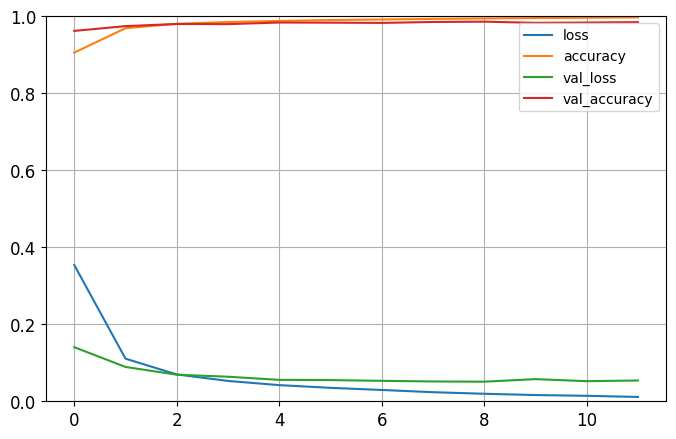

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Pour tester le modèle, appeller la méthode Model.evaluate sur les données de test


In [ ]:
eval_loss, eval_acc = model.evaluate(eval_dataset)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

40/40 [==============================] - 1s 20ms/step - loss: 0.0514 - accuracy: 0.9842
Eval loss: 0.05137942358851433, Eval accuracy: 0.9842000007629395


<!-- <img class="tfo-display-only-on-site" src="images/tensorboard_distributed_training_with_keras.png"/> -->

Sauvegarde du modèle dans une archive zip .keras.zip en utilisant Model.save

Après la sauvegarde, on peut charger le modèle et le tester.

In [ ]:
path = 'my_model.keras'

In [ ]:
model.save(path)

Maintenant, chargeons le modèle par l'utilsation du contexte Strategy.scope


In [ ]:
with strategy.scope():
  replicated_model = tf.keras.models.load_model(path)
  replicated_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

  eval_loss, eval_acc = replicated_model.evaluate(eval_dataset)
  print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

40/40 [==============================] - 4s 23ms/step - loss: 0.0514 - accuracy: 0.9842
Eval loss: 0.05137942358851433, Eval Accuracy: 0.9842000007629395
